In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0628/weights_KD_segformer_0628_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.3
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

Position_Embedding_0628_teacher_0.01
FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 813ms/step - loss: 0.0698
Average validation loss: 0.6683719754219055
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 828ms/step - loss: 0.0698 - val_loss: 0.6684
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 808ms/step - loss: 0.0500 - val_loss: 0.6684
Average validation loss: 0.5365437269210815
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 820ms/step - loss: 0.0500 - val_loss: 0.6025
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 806ms/step - loss: 0.0382 - val_loss: 0.6025
Average validation loss: 0.5270518660545349
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 816ms/step - loss: 0.0382 - val_loss: 0.5773
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\seg

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 943ms/step - loss: 3.0216e-04
Average validation loss: 1.0190599262714386
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 954ms/step - loss: 3.0216e-04 - val_loss: 1.0191
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 898ms/step - loss: 2.9544e-04 - val_loss: 1.0191
Average validation loss: 0.2370748221874237
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 908ms/step - loss: 2.9544e-04 - val_loss: 0.6281
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 894ms/step - loss: 2.8368e-04 - val_loss: 0.6281
Average validation loss: 0.4891352653503418
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 906ms/step - loss: 2.8368e-04 - val_loss: 0.5818
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 948ms/step - loss: 2.7490e-04 - val_loss: 0.5818
Average 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 812ms/step - loss: 1.1105e-04
Average validation loss: 0.106467521438996
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 823ms/step - loss: 1.1105e-04 - val_loss: 0.1065
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 791ms/step - loss: 9.7502e-05 - val_loss: 0.1065
Average validation loss: 0.11367896758019924
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 802ms/step - loss: 9.7502e-05 - val_loss: 0.1101
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 776ms/step - loss: 9.4425e-05 - val_loss: 0.1101
Average validation loss: 0.23376492783427238
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 788ms/step - loss: 9.4425e-05 - val_loss: 0.1513
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 780ms/step - loss: 9.5392e-05 - val_loss: 0.1513
Average validation loss: 0.09014672910173734
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 791ms/step - loss: 9.5392e-05 - val_loss: 0.1360
Saved model weigh

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 800ms/step - loss: 1.6702e-05
Average validation loss: 0.020988751435652375
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 812ms/step - loss: 1.6702e-05 - val_loss: 0.0210
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 828ms/step - loss: 1.3581e-05 - val_loss: 0.0210
Average validation loss: 0.020152641693130136
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 840ms/step - loss: 1.3581e-05 - val_loss: 0.0206
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 845ms/step - loss: 1.2137e-05 - val_loss: 0.0206
Average validation loss: 0.05746018560603261
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 855ms/step - loss: 1.2137e-05 - val_loss: 0.0329
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 53s 802ms/step - loss: 1.1749e-05 - val_

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 900ms/step - loss: 3.2731e-05
Average validation loss: 0.030916552990674973
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 911ms/step - loss: 3.2731e-05 - val_loss: 0.0309
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 786ms/step - loss: 2.1398e-05 - val_loss: 0.0309
Average validation loss: 0.039939282648265365
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 796ms/step - loss: 2.1398e-05 - val_loss: 0.0354
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 816ms/step - loss: 1.6619e-05 - val_loss: 0.0354
Average validation loss: 0.016255710180848836
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 825ms/step - loss: 1.6619e-05 - val_loss: 0.0290
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_25.pth'.
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 781ms/step - loss: 1.3801e-05 - val

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 855ms/step - loss: 4.4704e-05
Average validation loss: 0.021122560525933903
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 864ms/step - loss: 4.4704e-05 - val_loss: 0.0211
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 794ms/step - loss: 3.1367e-05 - val_loss: 0.0211
Average validation loss: 0.02440710101897518
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 804ms/step - loss: 3.1367e-05 - val_loss: 0.0228
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 60s 839ms/step - loss: 2.6816e-05 - val_loss: 0.0228
Average validation loss: 0.006161466667739053
24/24 ━━━━━━━━━━━━━━━━━━━━ 60s 849ms/step - loss: 2.6816e-05 - val_loss: 0.0172
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_30.pth'.
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 80s 796ms/step - loss: 2.2438e-05 - val_

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 782ms/step - loss: 6.0904e-05
Average validation loss: 0.035443261615000665
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 795ms/step - loss: 6.0904e-05 - val_loss: 0.0354
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 782ms/step - loss: 3.9713e-05 - val_loss: 0.0354
Average validation loss: 0.01953878375934437
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 795ms/step - loss: 3.9713e-05 - val_loss: 0.0275
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 784ms/step - loss: 2.9859e-05 - val_loss: 0.0275
Average validation loss: 0.014571090508252383
40/40 ━━━━━━━━━━━━━━━━━━━━ 96s 796ms/step - loss: 2.9859e-05 - val_loss: 0.0232
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 881ms/step - loss: 1.7021e-05
Average validation loss: 0.022312115024154384
48/48 ━━━━━━━━━━━━━━━━━━━━ 43s 893ms/step - loss: 1.7021e-05 - val_loss: 0.0223
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 81s 788ms/step - loss: 1.1820e-05 - val_loss: 0.0223
Average validation loss: 0.010469214418359721
48/48 ━━━━━━━━━━━━━━━━━━━━ 81s 799ms/step - loss: 1.1820e-05 - val_loss: 0.0164
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 120s 800ms/step - loss: 9.0048e-06 - val_loss: 0.0164
Average validation loss: 0.010872551172118014
48/48 ━━━━━━━━━━━━━━━━━━━━ 120s 812ms/step - loss: 9.0048e-06 - val_loss: 0.0146
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 159s 802ms/step - loss: 7.3656e-06 - 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 758ms/step - loss: 8.4635e-06
Average validation loss: 0.02015524324295776
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 770ms/step - loss: 8.4635e-06 - val_loss: 0.0202
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 88s 806ms/step - loss: 6.8364e-06 - val_loss: 0.0202
Average validation loss: 0.07852574211678334
56/56 ━━━━━━━━━━━━━━━━━━━━ 89s 817ms/step - loss: 6.8364e-06 - val_loss: 0.0493
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 136s 834ms/step - loss: 5.5875e-06 - val_loss: 0.0493
Average validation loss: 0.008433491889653462
56/56 ━━━━━━━━━━━━━━━━━━━━ 136s 846ms/step - loss: 5.5875e-06 - val_loss: 0.0357
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_70.pth'.
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 181s 800ms/step - loss: 4.8733e-06 - va

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 779ms/step - loss: 5.4145e-06
Average validation loss: 0.008660095743834972
64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 790ms/step - loss: 5.4145e-06 - val_loss: 0.0087
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 788ms/step - loss: 7.4840e-06 - val_loss: 0.0087
Average validation loss: 0.1409455130342394
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 799ms/step - loss: 7.4840e-06 - val_loss: 0.0748
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 152s 780ms/step - loss: 8.4497e-06 - val_loss: 0.0748
Average validation loss: 0.040159389725886285
64/64 ━━━━━━━━━━━━━━━━━━━━ 152s 791ms/step - loss: 8.4497e-06 - val_loss: 0.0633
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 203s 787ms/step - loss: 6.9698e-06 - val_loss: 0.0633
Average validation loss: 0.0211938030552119
64/64 ━━━━━━━━━━━━━━━━━━━━ 203s 798ms/step - loss: 6.9698e-06 - val_loss: 0.0527
Epoch 5/1

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 781ms/step - loss: 4.1410e-06
Average validation loss: 0.24132410581741068
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 792ms/step - loss: 4.1410e-06 - val_loss: 0.2413
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 798ms/step - loss: 3.6036e-06 - val_loss: 0.2413
Average validation loss: 0.04581863664659775
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 809ms/step - loss: 3.6036e-06 - val_loss: 0.1436
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 172s 790ms/step - loss: 3.8601e-06 - val_loss: 0.1436
Average validation loss: 0.023465236467826698
72/72 ━━━━━━━━━━━━━━━━━━━━ 173s 801ms/step - loss: 3.8601e-06 - val_loss: 0.1035
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 782ms/step - loss: 4.6329e-06
Average validation loss: 0.013919203917612321
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 793ms/step - loss: 4.6329e-06 - val_loss: 0.0139
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 128s 802ms/step - loss: 3.5705e-06 - val_loss: 0.0139
Average validation loss: 0.004958385499776341
80/80 ━━━━━━━━━━━━━━━━━━━━ 129s 814ms/step - loss: 3.5705e-06 - val_loss: 0.0094
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 195s 827ms/step - loss: 3.6450e-06 - val_loss: 0.0094
Average validation loss: 0.03025267624761909
80/80 ━━━━━━━━━━━━━━━━━━━━ 196s 838ms/step - loss: 3.6450e-06 - val_loss: 0.0164
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 261s 808ms/step - loss: 3.2799e-06

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 784ms/step - loss: 7.8937e-06
Average validation loss: 0.10032858249420921
96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 795ms/step - loss: 7.8937e-06 - val_loss: 0.1003
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 151s 780ms/step - loss: 5.5071e-06 - val_loss: 0.1003
Average validation loss: 0.018129606265574694
96/96 ━━━━━━━━━━━━━━━━━━━━ 153s 792ms/step - loss: 5.5071e-06 - val_loss: 0.0592
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 228s 787ms/step - loss: 4.3695e-06 - val_loss: 0.0592
Average validation loss: 0.0313006728538312
96/96 ━━━━━━━━━━━━━━━━━━━━ 229s 799ms/step - loss: 4.3695e-06 - val_loss: 0.0499
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 304s 775ms/step - loss: 3.7469e-06 -

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 795ms/step - loss: 1.3983e-05
Average validation loss: 0.011798982912053665
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 806ms/step - loss: 1.3983e-05 - val_loss: 0.0118
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 193s 803ms/step - loss: 9.4763e-06 - val_loss: 0.0118
Average validation loss: 0.014535364873396853
120/120 ━━━━━━━━━━━━━━━━━━━━ 195s 814ms/step - loss: 9.4763e-06 - val_loss: 0.0132
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 292s 815ms/step - loss: 7.3251e-06 - val_loss: 0.0132
Average validation loss: 0.015443269109042982
120/120 ━━━━━━━━━━━━━━━━━━━━ 294s 826ms/step - loss: 7.3251e-06 - val_loss: 0.0139
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 389s 794ms/step - loss: 6.1109e-06 - val_loss: 0.0139
Average validation loss: 0.05314400161926945
120/120 ━━━━━━━━━━━━━━━━━━━━ 390s 805ms/step - loss: 6.1109e-06 - val_lo

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 112s 778ms/step - loss: 1.2424e-05
Average validation loss: 0.021106441532740265
144/144 ━━━━━━━━━━━━━━━━━━━━ 114s 789ms/step - loss: 1.2424e-05 - val_loss: 0.0211
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 226s 782ms/step - loss: 8.9628e-06 - val_loss: 0.0211
Average validation loss: 0.009727203670384673
144/144 ━━━━━━━━━━━━━━━━━━━━ 228s 793ms/step - loss: 8.9628e-06 - val_loss: 0.0154
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 341s 784ms/step - loss: 7.1303e-06 - val_loss: 0.0154
Average validation loss: 0.007486677463425117
144/144 ━━━━━━━━━━━━━━━━━━━━ 342s 795ms/step - loss: 7.1303e-06 - val_loss: 0.0128
Saved model weights to 'c:\天_11157065\git\RipplesDetectio

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 779ms/step - loss: 5.0489e-06
Average validation loss: 0.008796241160598583
160/160 ━━━━━━━━━━━━━━━━━━━━ 126s 790ms/step - loss: 5.0489e-06 - val_loss: 0.0088
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 249s 766ms/step - loss: 3.9865e-06 - val_loss: 0.0088
Average validation loss: 0.011289689753903076
160/160 ━━━━━━━━━━━━━━━━━━━━ 251s 777ms/step - loss: 3.9865e-06 - val_loss: 0.0100
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 382s 820ms/step - loss: 3.3999e-06 - val_loss: 0.0100
Average validation loss: 0.00665321975830011
160/160 ━━━━━━━━━━━━━━━━━━━━ 384s 831ms/step - loss: 3.3999e-06 - val_loss: 0.0089
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_200.pth'.
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 514s 813ms/step - 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 165s 826ms/step - loss: 4.8986e-06
Average validation loss: 0.03993654798716307
200/200 ━━━━━━━━━━━━━━━━━━━━ 167s 837ms/step - loss: 4.8986e-06 - val_loss: 0.0399
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 331s 816ms/step - loss: 3.9507e-06 - val_loss: 0.0399
Average validation loss: 0.007011106617719634
200/200 ━━━━━━━━━━━━━━━━━━━━ 333s 827ms/step - loss: 3.9507e-06 - val_loss: 0.0235
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 493s 800ms/step - loss: 3.3912e-06 - val_loss: 0.0235
Average validation loss: 0.008116369202398346
200/200 ━━━━━━━━━━━━━━━━━━━━ 495s 811ms/step - loss: 3.3912e-06 - val_loss: 0.0184
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 655s 797ms/step - 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 188s 782ms/step - loss: 3.2643e-06
Average validation loss: 0.061211739130532225
240/240 ━━━━━━━━━━━━━━━━━━━━ 190s 793ms/step - loss: 3.2643e-06 - val_loss: 0.0612
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 377s 778ms/step - loss: 2.4187e-06 - val_loss: 0.0612
Average validation loss: 0.035625119514269936
240/240 ━━━━━━━━━━━━━━━━━━━━ 380s 790ms/step - loss: 2.4187e-06 - val_loss: 0.0484
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_30\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 567s 779ms/step - loss: 2.2946e-06 - val_loss: 0.0484
Average validation loss: 0.07155355109421109
240/240 ━━━━━━━━━━━━━━━━━━━━ 570s 791ms/step - loss: 2.2946e-06 - val_loss: 0.0561
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 756s 777ms/step - 

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.24012624204158783, 0.21534723410382867, 0.07788060132414104, 0.042515489892393815, 0.03619634237186983, 0.03049278032151051, 0.015450617132242772, 0.029616332980998174, 0.020613017981938486, 0.04198475277262333, 0.07348417279582159, 0.05626561473679612, 0.028010243412136333, 0.018478944504808168, 0.030286975798958896, 0.03560349374144576, 0.038972930563095295, 0.02904804882664285]
std_val_losses =  [0.14367491624070597, 0.2052775231317791, 0.059840230011025196, 0.0392623721554753, 0.037779685841448155, 0.04281372360727754, 0.00809733089730793, 0.03755211009970008, 0.021813389687997134, 0.05358400353463979, 0.07048982440188128, 0.06795945724808503, 0.028541997912188536, 0.012292258570250595, 0.04089589956766232, 0.06562806737572949, 0.05717453416770961, 0.032535124742875954]


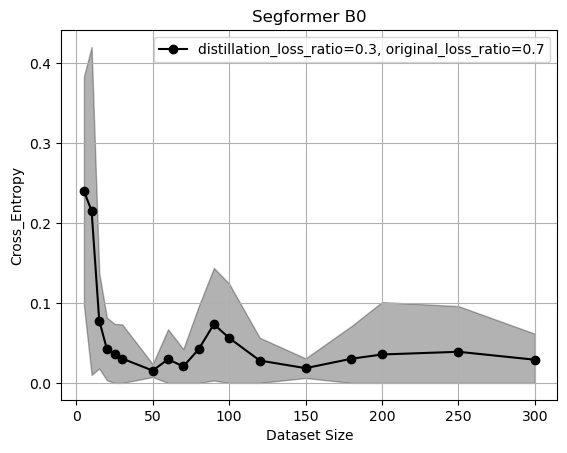

In [3]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0628')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0628_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0628_{int(teacher_ratio*100)}.png"))

plt.show()